## **03 Reviews Exploratory Data Analysis**
This notebook explores the review dataset to investigate any interesting results.

### **Notebook Objectives**
1. Aggregate the data to look for interesting comparisons.
2. Visualize the review data using various plotting techniques.

In [1]:
import pandas as pd
import re
from pathlib import Path
import random
random.seed(11)
import numpy as np
np.random.seed(11)
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import seaborn as sns
sns.set()

In [113]:
# Load brewery review data
filepath = Path('../assets/brewery_reviews.csv') 
df = pd.read_csv(filepath)
print(f'Total Reviews: {df.shape[0]}')

# TODO clean incorrectly parsed ratings
# For now filter them out
original = df.shape[0]
df = df.copy().query('rating == 1 | rating == 2 | rating == 3 | rating == 4 | rating == 5')
dropped = original - df.shape[0]
print(f'Dropping {dropped} rows due to rating errors')

# Group by brewery
aggregate = {}
columns = ['name', 'state', 'city', 'street', 'longitude', 'latitude']
for column in columns:
    aggregate[column] = 'max'
aggregate['review'] = 'count'
aggregate['rating'] = 'mean'
brewery_df = df.groupby(by='obdb_id').agg(aggregate).reset_index()
brewery_df = brewery_df.rename(columns={'review': 'reviews', 'rating': 'avg_rating'})
print(f'Total Breweries: {df.shape[0]}')
brewery_df.head(5)

Total Reviews: 16727
Dropping 36 rows due to rating errors
Total Breweries: 16691


,obdb_id,name,state,city,street,longitude,latitude,reviews,avg_rating
0,10th-district-brewing-company-abington,10th District Brewing Company,Massachusetts,Abington,491 Washington St,-70.945941,42.105918,7,4.571429
1,12-gates-brewing-company-williamsville,12 Gates Brewing Company,New York,Williamsville,80 Earhart Dr Ste 20,NaN,NaN,30,4.600000
2,14th-star-brewing-saint-albans,14th Star Brewing,Vermont,Saint Albans,133 N Main St Ste 7,-73.082451,44.814365,30,4.100000
3,16-stone-brewpub-holland-patent,16 Stone Brewpub,New York,Holland Patent,9542 Main St,-75.256519,43.242112,15,5.000000
4,1940s-brewing-company-holbrook,1940's Brewing Company,New York,Holbrook,1337 Lincoln Ave Unit 1,-73.085702,40.799628,6,4.500000


In [114]:
# Group by city
aggregate = {'state': 'max',
             'obdb_id': 'count',
             'reviews': 'sum',
             'avg_rating': 'mean'}
city_df = brewery_df.groupby(by='city').agg(aggregate).reset_index()
city_df = city_df.rename(columns={'obdb_id': 'breweries'})
city_df = city_df.sort_values(by='breweries', ascending=False).reset_index(drop=True)
city_df.head(10)

,city,state,breweries,reviews,avg_rating
0,Brooklyn,New York,15,305,4.206587
1,Buffalo,New York,14,490,4.188700
2,Portland,Maine,14,366,4.208615
3,Rochester,New York,12,312,4.395799
4,Manchester,New York,7,136,4.008202
5,Syracuse,New York,7,116,3.975903
6,Burlington,Vermont,7,215,4.339221
7,Providence,Rhode Island,6,141,4.358201
8,Portsmouth,Rhode Island,6,111,4.508502
9,Middletown,Rhode Island,5,158,4.392344


Not surprised that Brooklyn, NY has the most breweries for the current dataset (7 states in the Northeast). Was pleasantly surprised to see Providence, RI in the top 10 though given its relatively small size.

In [118]:
# Sort by average rating for cities with multiple breweries
city_avg_df = city_df.query('breweries >= 5')
city_avg_df = city_avg_df.sort_values(by='avg_rating', ascending=False).reset_index(drop=True)
city_avg_df.head(10)

,city,state,breweries,reviews,avg_rating
0,Portsmouth,Rhode Island,6,111,4.508502
1,Bangor,Maine,5,176,4.472521
2,Long Island City,New York,5,114,4.469205
3,Rochester,New York,12,312,4.395799
4,Middletown,Rhode Island,5,158,4.392344
5,Providence,Rhode Island,6,141,4.358201
6,Burlington,Vermont,7,215,4.339221
7,Riverhead,New York,5,121,4.325212
8,Boston,Massachusetts,5,137,4.208849
9,Portland,Maine,14,366,4.208615


Hard to draw too many insights from this, but perhaps it indicates these top cities have breweries that generally exceed reviewers' expectations or the reviewers visiting these cities are typically a positive bunch.

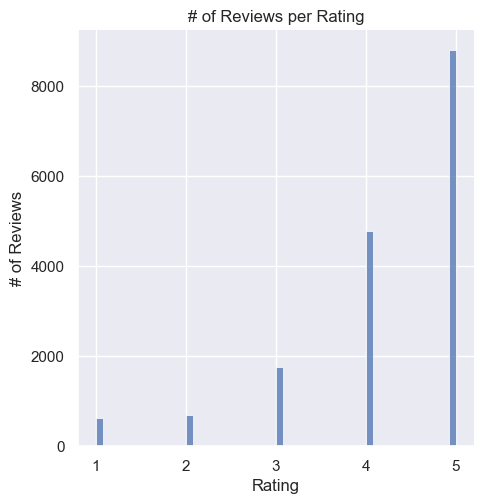

In [80]:
sns.displot(data=df, x='rating')
plt.xlabel('Rating')
plt.ylabel('# of Reviews')
plt.title('# of Reviews per Rating')
plt.show()

Most Tripadvisor reviewers leave 5 star ratings. I would have expected a higher proportion of 1 star ratings as such experiences may lead to more motivation to leave a review, but that is not the case here.

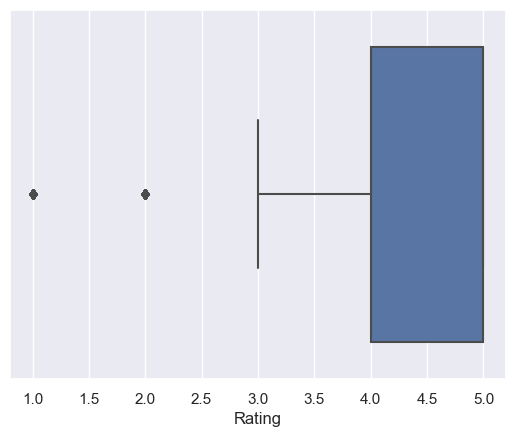

In [81]:
sns.boxplot(data=df, x='rating')
plt.xlabel('Rating')
plt.show()

In [82]:
# Get word counts
nlp = spacy.load('en_core_web_sm')
tokens = []
no_stopwords = []
sents = []
for review in df['review']:
    doc = nlp(review)
    tokens.append(len(doc))
    sents.append(len(list(doc.sents))) 
    count = 0 
    for token in doc:
        if not token.is_stop:
            count += 1
    no_stopwords.append(count)
df['tokens'] = tokens
df['no_stopwords'] = no_stopwords
df['sents'] = sents

In [85]:
df.head(3)

,obdb_id,name,state,city,street,longitude,latitude,website_url,rating,review,tokens,sents,no_stopwords
0,10th-district-brewing-company-abington,10th District Brewing Company,Massachusetts,Abington,491 Washington St,-70.945941,42.105918,http://www.10thdistrictbrewing.com,5.0,Stout and Double IPAs...WOW!!. Only open W and...,46,4,29
1,10th-district-brewing-company-abington,10th District Brewing Company,Massachusetts,Abington,491 Washington St,-70.945941,42.105918,http://www.10thdistrictbrewing.com,5.0,"Good Local Beer!. Good beer, brewed right on s...",48,6,30
2,10th-district-brewing-company-abington,10th District Brewing Company,Massachusetts,Abington,491 Washington St,-70.945941,42.105918,http://www.10thdistrictbrewing.com,4.0,"Tasty, fresh Brew. Went for a quick taste of t...",159,10,92


In [86]:
df.describe()

,longitude,latitude,rating,tokens,sents,no_stopwords
count,14516.000000,14516.000000,16691.000000,16691.000000,16691.000000,16691.000000
mean,-72.960837,42.767983,4.226350,80.484573,6.486070,44.058774
std,2.592952,1.133013,1.042272,62.546379,3.556541,31.723488
min,-79.349384,40.575027,1.000000,3.000000,1.000000,3.000000
25%,-73.985385,41.914457,4.000000,46.000000,4.000000,26.000000
50%,-72.662665,42.825364,5.000000,60.000000,6.000000,34.000000
75%,-71.093978,43.617153,5.000000,92.000000,8.000000,50.000000
max,-67.458046,47.256722,5.000000,1062.000000,48.000000,563.000000


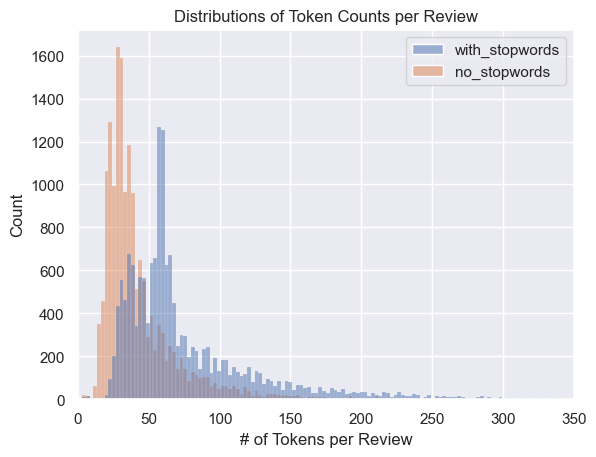

In [87]:
# Explore word counts
data = df[['tokens', 'no_stopwords']]
data = data.rename(columns={'tokens': 'with_stopwords'})
sns.histplot(data=data, bins=400)
plt.xlabel('# of Tokens per Review')
plt.ylabel('Count')
plt.title('Distributions of Token Counts per Review')
plt.xlim([0, 350])
plt.show()

Excluding stopwords from the count shifts the distribution to the left and up as expected. It also decreases the overall distribution range.

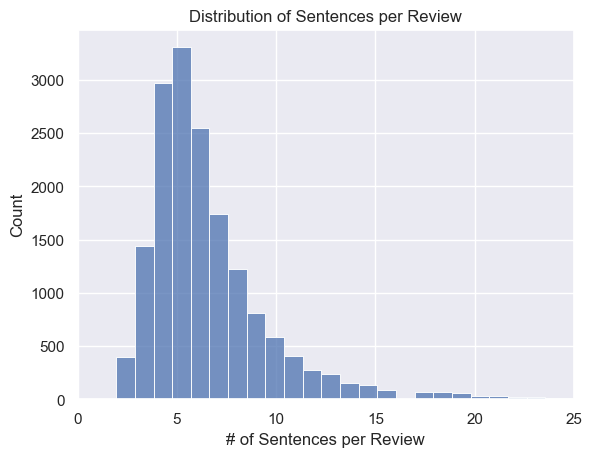

In [88]:
# Explore sentence counts
sns.histplot(df, x='sents', bins=50)
plt.xlabel('# of Sentences per Review')
plt.ylabel('Count')
plt.title('Distribution of Sentences per Review')
plt.xlim([0, 25])
plt.show()

Most people appear to write 5 sentences. There are also quite a few novelists out there writing 15+ sentences.

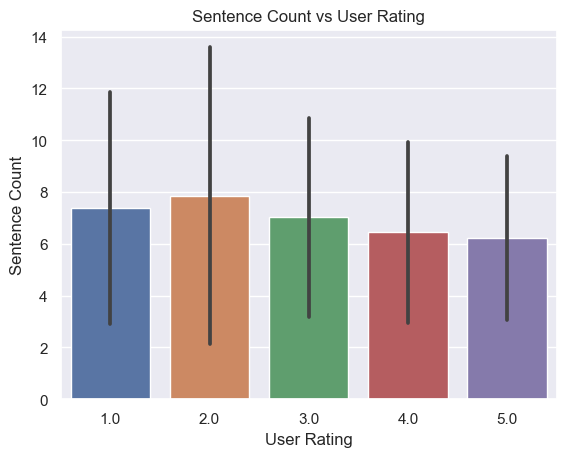

In [72]:
# Explore counts vs user rating
sns.barplot(data=df, x='rating', y='sents', errorbar="sd")
plt.xlabel('User Rating')
plt.ylabel('Sentence Count')
plt.title('Sentence Count vs User Rating')
plt.show()

Sentence count looks insensitive to the user's rating. The large standard deviation among sentence counts is also striking.